In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
from scipy import stats
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import time

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import folium
import fbprophet
plt.style.use('fivethirtyeight')
#import pickle
import gc
import warnings
warnings.filterwarnings('ignore')

In [5]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import itertools
from datetime import timedelta

from joblib import Parallel, delayed
import multiprocessing

In [6]:
train_16 = pd.read_csv('D:/ML work/Zillow Home Value Prediction/train_2016_v2/train_2016_v2.csv')
properties_16 = pd.read_csv('D:/ML work/Zillow Home Value Prediction/properties_2016/properties_2016.csv')

train_17 = pd.read_csv('D:/ML work/Zillow Home Value Prediction/train_2017.csv/train_2017.csv')
properties_17 = pd.read_csv('D:/ML work/Zillow Home Value Prediction/properties_2017.csv/properties_2017.csv')

In [7]:
#properties_df = pd.DataFrame()

In [8]:
#for chunk in properties:
#    properties_df = properties_df.append(chunk, ignore_index = True)

In [9]:
train_16.shape, properties_16.shape, train_17.shape, properties_17.shape

((90275, 3), (2985217, 58), (77613, 3), (2985217, 58))

In [10]:
train_17.tail()

,parcelid,logerror,transactiondate
77608,10833991,-0.002245,2017-09-20
77609,11000655,0.020615,2017-09-20
77610,17239384,0.013209,2017-09-21
77611,12773139,0.037129,2017-09-21
77612,12826780,0.007204,2017-09-25


In [11]:
train_16['transactiondate'] = pd.to_datetime(train_16['transactiondate'], format = '%Y-%m-%d')
train_17['transactiondate'] = pd.to_datetime(train_17['transactiondate'], format = '%Y-%m-%d')

In [12]:
properties_df_16 = properties_16.merge(train_16, how = 'left', on = 'parcelid')
del properties_16, train_16

properties_df_17 = properties_17.merge(train_17, how = 'left', on = 'parcelid')
del properties_17, train_17

In [13]:
#properties_df = pd.concat([properties_df_16, properties_df_17])

In [14]:
properties_df = properties_df_16

In [15]:
del properties_df_16#, properties_df_17
gc.collect()

88

In [16]:
properties_df.shape

(2985342, 60)

In [17]:
properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985342 entries, 0 to 2985341
Data columns (total 60 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottub

In [18]:
#del properties_df
#gc.collect()

In [19]:
properties_df.drop(['taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'], axis = 1, inplace = True)

In [20]:
for c, dtype in zip(properties_df.columns, properties_df.dtypes):
    if dtype == np.float64:
        properties_df[c] = properties_df[c].astype(np.float32) 
    elif dtype == np.int64:
        properties_df[c] = properties_df[c].astype(np.int32)
#end for loop

gc.collect()

74

In [21]:
properties_df.get_dtype_counts()

datetime64[ns]     1
float32           50
int32              1
object             5
dtype: int64

In [22]:
error_mean = np.mean(properties_df['logerror'])
error_median = np.median(properties_df['logerror'].dropna())
error_std = np.std(properties_df['logerror'])

error_mean, error_median, error_std

(0.01145784743130207, 0.0060000001, 0.16107094287872314)

In [23]:
properties_df.count()

parcelid                        2985342
airconditioningtypeid            811552
architecturalstyletypeid           6062
basementsqft                       1628
bathroomcnt                     2973880
bedroomcnt                      2973892
buildingclasstypeid               12629
buildingqualitytypeid           1938568
calculatedbathnbr               2856424
decktypeid                        17096
finishedfloor1squarefeet         202723
calculatedfinishedsquarefeet    2929774
finishedsquarefeet12            2709295
finishedsquarefeet13               7672
finishedsquarefeet15             190807
finishedsquarefeet50             202723
finishedsquarefeet6               22003
fips                            2973905
fireplacecnt                     312647
fullbathcnt                     2856424
garagecarcnt                     883307
garagetotalsqft                  883307
hashottuborspa                    69016
heatingorsystemtypeid           1806476
latitude                        2973905


In [24]:
properties_df['calculatedbathnbr'] = np.where(np.isnan(properties_df['calculatedbathnbr']), properties_df['bathroomcnt'], properties_df['calculatedbathnbr'])

In [25]:
#drop bathroomcnt
properties_df.drop('bathroomcnt', axis = 1, inplace = True)

In [26]:
# So we can safely drop one column of them
properties_df.drop('finishedsquarefeet50', axis = 1, inplace = True)

In [27]:
# if condition is satisfied then replace with True else False
# assume that if fireplacecnt is null, then fireplaceflg will be false
properties_df['fireplaceflag'] = np.where(pd.isnull(properties_df['fireplaceflag']) & pd.notnull(properties_df['fireplacecnt']) & properties_df['fireplacecnt'] > 0, True, False)

In [28]:
properties_df['fireplaceflag'].count()
# fireplaceflag is recovered

2985342

In [29]:
index = properties_df['fireplacecnt'].isnull()
properties_df.loc[index, 'fireplacecnt'] = 0

In [30]:
properties_df['house_age'] = datetime.now().date().year - properties_df['yearbuilt']

In [31]:
#assume if taxdelinquencyflag is null then False (doesn't exist)
index = properties_df['taxdelinquencyflag'].isnull()
properties_df.loc[index, 'taxdelinquencyflag'] = False

In [32]:
properties_df.drop('pooltypeid10', axis = 1, inplace = True)

In [33]:
# this does not make sense in theory. it should be assigned poolcnt - pooltypeid7
index = (properties_df['pooltypeid2'].isnull()) & (properties_df['hashottuborspa'] == True) & (properties_df['poolcnt'].notnull()) & ((properties_df['pooltypeid7']).notnull())
properties_df.loc[index, 'pooltypeid2'] = properties_df.loc[index, 'poolcnt'] - properties_df.loc[index, 'pooltypeid7']

In [34]:
index = (properties_df['pooltypeid2'].isnull()) & (properties_df['hashottuborspa'] == True) & (properties_df['poolcnt'].notnull()) & ((properties_df['pooltypeid7']).isnull())
properties_df.loc[index, 'pooltypeid2'] = properties_df['poolcnt']

index = (properties_df['pooltypeid2'].isnull()) & (properties_df['poolcnt'].isnull())
properties_df.loc[index, 'pooltypeid2'] = 0.0

In [35]:
#this does not make sense, assign poolcnt to pooltypeid7
index = (properties_df['pooltypeid7'].isnull()) & (properties_df['poolcnt'].notnull() & (properties_df['pooltypeid2'].notnull())) 
properties_df.loc[index, 'pooltypeid7'] = properties_df.loc[index, 'poolcnt'] - properties_df.loc[index, 'pooltypeid2']
 

In [36]:
index = properties_df.hashottuborspa.isnull()
properties_df.loc[index, 'hashottuborspa'] = False

index = properties_df.pooltypeid2.isnull()
properties_df.loc[index,'pooltypeid2'] = 0

index = properties_df.pooltypeid7.isnull()
properties_df.loc[index,'pooltypeid7'] = 0

index = properties_df.poolcnt.isnull()
properties_df.loc[index,'poolcnt'] = 0

index = (properties_df.poolcnt == 0)
properties_df.loc[index, 'poolsizesum'] = 0

In [37]:
# replace 'Y' with True in taxdelinquencyflag
index = (properties_df.taxdelinquencyflag == 'Y')
properties_df.loc[index,'taxdelinquencyflag'] = True

In [38]:
properties_df['taxdelinquencyflag'] = properties_df.taxdelinquencyflag.astype(np.bool)

In [39]:
properties_df['hashottuborspa'] = properties_df.hashottuborspa.astype(np.bool)

In [40]:
#Null in garage count means there are no garages
index = properties_df.garagecarcnt.isnull()
properties_df.loc[index,'garagecarcnt'] = 0

In [41]:
#error in calculation of the finished living area of home
properties_df['N-LivingAreaError'] = properties_df['calculatedfinishedsquarefeet'] / properties_df['finishedsquarefeet12']


In [42]:
#proportion of living area
properties_df['N-LivingAreaProp'] = properties_df['calculatedfinishedsquarefeet'] / properties_df['lotsizesquarefeet']
properties_df['N-LivingAreaProp2'] = properties_df['finishedsquarefeet12'] / properties_df['finishedsquarefeet15']

In [43]:
#Amout of extra space
properties_df['N-ExtraSpace'] = properties_df['lotsizesquarefeet'] - properties_df['calculatedfinishedsquarefeet'] 
properties_df['N-ExtraSpace-2'] = properties_df['finishedsquarefeet15'] - properties_df['finishedsquarefeet12']

In [44]:
#Average room size
properties_df['N-AvRoomSize'] = properties_df['calculatedfinishedsquarefeet'] / properties_df['roomcnt']

In [45]:
#Total number of rooms
properties_df['N-TotalRooms'] = properties_df['calculatedbathnbr'] + properties_df['bedroomcnt']

In [46]:
# Number of Extra rooms
properties_df['N-ExtraRooms'] = properties_df['roomcnt'] - properties_df['N-TotalRooms']

In [47]:



# #Ratio of the built structure value to land area

# properties_df['N-ValueProp'] = properties_df['structuretaxvaluedollarcnt']/properties_df['landtaxvaluedollarcnt']

In [48]:
#Does property have a garage, pool or hot tub and AC?
properties_df['N-GarPoolAC'] = ((properties_df['garagecarcnt']>0) & (properties_df['hashottuborspa']>0) & (properties_df['airconditioningtypeid']!=5))*1

In [49]:
properties_df["N-location"] = properties_df["latitude"] + properties_df["longitude"]
properties_df["N-location-2"] = properties_df["latitude"] * properties_df["longitude"]
properties_df["N-location-2round"] = properties_df["N-location-2"].round(-4)

properties_df["N-latitude-round"] = properties_df["latitude"].round(-4)
properties_df["N-longitude-round"] = properties_df["longitude"].round(-4)

In [50]:
# #Ratio of tax of property over parcel
# properties_df['N-ValueRatio'] = properties_df['taxvaluedollarcnt'] / properties_df['taxamount']

# #TotalTaxScore
# properties_df['N-TaxScore'] = properties_df['taxvaluedollarcnt']*properties_df['taxamount']

#polnomials of tax delinquency year
properties_df["N-taxdelinquencyyear-2"] = properties_df["taxdelinquencyyear"] ** 2
properties_df["N-taxdelinquencyyear-3"] = properties_df["taxdelinquencyyear"] ** 3

#Length of time since unpaid taxes
properties_df['N-life'] = 2018 - properties_df['taxdelinquencyyear']

In [51]:
#Number of properties in the zip
zip_count = properties_df['regionidzip'].value_counts().to_dict()
properties_df['N-zip_count'] = properties_df['regionidzip'].map(zip_count)

#Number of properties in the city
city_count = properties_df['regionidcity'].value_counts().to_dict()
properties_df['N-city_count'] = properties_df['regionidcity'].map(city_count)

#Number of properties in the city
region_count = properties_df['regionidcounty'].value_counts().to_dict()
properties_df['N-county_count'] = properties_df['regionidcounty'].map(city_count)

In [52]:
#Indicator whether it has AC or not
properties_df['N-ACInd'] = (properties_df['airconditioningtypeid']!=5)*1

In [53]:
#Indicator whether it has Heating or not 
properties_df['N-HeatInd'] = (properties_df['heatingorsystemtypeid']!=13)*1

In [54]:
#polnomials of the variable
properties_df["N-structuretaxvaluedollarcnt-2"] = properties_df["structuretaxvaluedollarcnt"] ** 2
properties_df["N-structuretaxvaluedollarcnt-3"] = properties_df["structuretaxvaluedollarcnt"] ** 3

#Average structuretaxvaluedollarcnt by city
group = properties_df.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
properties_df['N-Avg-structuretaxvaluedollarcnt'] = properties_df['regionidcity'].map(group)

#Deviation away from average
properties_df['N-Dev-structuretaxvaluedollarcnt'] = abs((properties_df['structuretaxvaluedollarcnt'] - properties_df['N-Avg-structuretaxvaluedollarcnt']))/properties_df['N-Avg-structuretaxvaluedollarcnt']

In [55]:
properties_df['hashottuborspa'] = properties_df['hashottuborspa'].astype(np.int32)
properties_df['fireplaceflag'] = properties_df['fireplaceflag'].astype(np.int32)
properties_df['taxdelinquencyflag'] = properties_df['taxdelinquencyflag'].astype(np.int32)
properties_df['fireplaceflag'] = properties_df['fireplaceflag'].astype(np.int32)

In [56]:
properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985342 entries, 0 to 2985341
Data columns (total 81 columns):
parcelid                            int32
airconditioningtypeid               float32
architecturalstyletypeid            float32
basementsqft                        float32
bedroomcnt                          float32
buildingclasstypeid                 float32
buildingqualitytypeid               float32
calculatedbathnbr                   float32
decktypeid                          float32
finishedfloor1squarefeet            float32
calculatedfinishedsquarefeet        float32
finishedsquarefeet12                float32
finishedsquarefeet13                float32
finishedsquarefeet15                float32
finishedsquarefeet6                 float32
fips                                float32
fireplacecnt                        float32
fullbathcnt                         float32
garagecarcnt                        float32
garagetotalsqft                     float32
hashottub

In [57]:

count = properties_df.count()

for j in properties_df.columns:
    if (properties_df[j].count() < 5970758):
        print(j)

parcelid
airconditioningtypeid
architecturalstyletypeid
basementsqft
bedroomcnt
buildingclasstypeid
buildingqualitytypeid
calculatedbathnbr
decktypeid
finishedfloor1squarefeet
calculatedfinishedsquarefeet
finishedsquarefeet12
finishedsquarefeet13
finishedsquarefeet15
finishedsquarefeet6
fips
fireplacecnt
fullbathcnt
garagecarcnt
garagetotalsqft
hashottuborspa
heatingorsystemtypeid
latitude
longitude
lotsizesquarefeet
poolcnt
poolsizesum
pooltypeid2
pooltypeid7
propertycountylandusecode
propertylandusetypeid
propertyzoningdesc
rawcensustractandblock
regionidcity
regionidcounty
regionidneighborhood
regionidzip
roomcnt
storytypeid
threequarterbathnbr
typeconstructiontypeid
unitcnt
yardbuildingsqft17
yardbuildingsqft26
yearbuilt
numberofstories
fireplaceflag
structuretaxvaluedollarcnt
assessmentyear
taxdelinquencyflag
taxdelinquencyyear
censustractandblock
logerror
transactiondate
house_age
N-LivingAreaError
N-LivingAreaProp
N-LivingAreaProp2
N-ExtraSpace
N-ExtraSpace-2
N-AvRoomSize
N-Tota

In [58]:
properties_df['airconditioningtypeid'].fillna(value=0.0, inplace = True)
properties_df['architecturalstyletypeid'].fillna(value=0.0, inplace = True)
properties_df['basementsqft'].fillna(value=0.0, inplace = True)
properties_df['bedroomcnt'].fillna(value=0.0, inplace = True)
properties_df['buildingclasstypeid'].fillna(value=0.0, inplace = True)
properties_df['buildingqualitytypeid'].fillna(value=0.0, inplace = True)

properties_df['decktypeid'].fillna(value=0.0, inplace = True)
properties_df['finishedfloor1squarefeet'].fillna(value=0.0, inplace = True)

properties_df['finishedsquarefeet12'].fillna(value=0.0, inplace = True)
properties_df['finishedsquarefeet13'].fillna(value=0.0, inplace = True)
properties_df['finishedsquarefeet15'].fillna(value=0.0, inplace = True)
properties_df['finishedsquarefeet6'].fillna(value=0.0, inplace = True)
properties_df['fips'].fillna(value=0.0, inplace = True)
properties_df['censustractandblock'].fillna(value = 0.0, inplace = True)
properties_df['taxdelinquencyyear'].fillna(value = 0.0, inplace = True)
properties_df['heatingorsystemtypeid'].fillna(value=0.0, inplace = True)
properties_df['latitude'].fillna(value=0.0, inplace = True)
properties_df['longitude'].fillna(value=0.0, inplace = True)
properties_df['propertylandusetypeid'].fillna(value = 0.0, inplace = True)
properties_df['rawcensustractandblock'].fillna(value = 0.0, inplace = True)

properties_df['regionidcity'].fillna(value = 0.0, inplace = True)
properties_df['regionidcounty'].fillna(value = 0.0, inplace = True)
properties_df['regionidneighborhood'].fillna(value = 0.0, inplace = True)
properties_df['regionidzip'].fillna(value = 0.0, inplace = True)
properties_df['roomcnt'].fillna(value = 0.0, inplace = True)
properties_df['yearbuilt'].fillna(value = 0.0, inplace = True)
properties_df['structuretaxvaluedollarcnt'].fillna(value = 0.0, inplace = True)
# properties_df['taxvaluedollarcnt'].fillna(value = 0.0, inplace = True)
properties_df['assessmentyear'].fillna(value = 0.0, inplace = True)
# properties_df['landtaxvaluedollarcnt'].fillna(value = 0.0, inplace = True)
# properties_df['taxamount'].fillna(value = 0.0, inplace = True)
properties_df['numberofstories'].fillna(value = 0.0, inplace = True)

properties_df['poolsizesum'].fillna(value=0.0, inplace = True)
properties_df['house_age'].fillna(value=1.0, inplace = True)
properties_df['N-LivingAreaError'].fillna(value=0.0, inplace = True)
properties_df['N-LivingAreaProp'].fillna(value=0.0, inplace = True)
properties_df['N-ExtraSpace'].fillna(value=0.0, inplace = True)
properties_df['N-TotalRooms'].fillna(value=0.0, inplace = True)
properties_df['N-ExtraRooms'].fillna(value=0.0, inplace = True)
# properties_df['N-ValueProp'].fillna(value=0.0, inplace = True)
properties_df['N-location'].fillna(value=0.0, inplace = True)
properties_df['N-location-2'].fillna(value=0.0, inplace = True)
properties_df['N-location-2round'].fillna(value=0.0, inplace = True)
properties_df['N-latitude-round'].fillna(value=0.0, inplace = True)
properties_df['N-longitude-round'].fillna(value=0.0, inplace = True)
# properties_df['N-ValueRatio'].fillna(value=0.0, inplace = True)
# properties_df['N-TaxScore'].fillna(value=0.0, inplace = True)
properties_df['N-taxdelinquencyyear-2'].fillna(value=0.0, inplace = True)
properties_df['N-taxdelinquencyyear-3'].fillna(value=0.0, inplace = True)
properties_df['N-life'].fillna(value=0.0, inplace = True)
properties_df['N-zip_count'].fillna(value=0.0, inplace = True)
properties_df['N-city_count'].fillna(value=0.0, inplace = True)
properties_df['N-structuretaxvaluedollarcnt-2'].fillna(value=0.0, inplace = True)
properties_df['N-structuretaxvaluedollarcnt-3'].fillna(value=0.0, inplace = True)
properties_df['N-Avg-structuretaxvaluedollarcnt'].fillna(value=0.0, inplace = True)
properties_df['N-Dev-structuretaxvaluedollarcnt'].fillna(value=0.0, inplace = True)


In [59]:
properties_df['storytypeid'].fillna(value=0.0, inplace = True)

In [60]:
properties_df['threequarterbathnbr'].fillna(value=0.0, inplace = True)

In [61]:
properties_df['typeconstructiontypeid'].fillna(value=0.0, inplace = True)

In [62]:
properties_df['unitcnt'].fillna(value=1.0, inplace = True)

In [63]:
properties_df['calculatedfinishedsquarefeet'].fillna(value=0.0,inplace = True)

In [64]:
properties_df['yardbuildingsqft17'].fillna(value=0.0,inplace = True)

In [65]:
properties_df['yardbuildingsqft26'].fillna(value=0.0,inplace = True)

In [66]:
properties_df['calculatedbathnbr'].fillna(value=0.0, inplace = True)

properties_df['fullbathcnt'].fillna(value=0.0, inplace = True)

properties_df['garagetotalsqft'].fillna(value=0.0, inplace = True)

properties_df['lotsizesquarefeet'].fillna(value=0.0, inplace = True)

In [67]:
properties_df.drop(['N-county_count', 'N-ExtraSpace-2', 'N-LivingAreaProp2'], inplace = True, axis = 1)

In [68]:
#because this column contains so much inf values
properties_df.drop(['N-AvRoomSize'], axis = 1, inplace = True)

In [69]:
properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985342 entries, 0 to 2985341
Data columns (total 77 columns):
parcelid                            int32
airconditioningtypeid               float32
architecturalstyletypeid            float32
basementsqft                        float32
bedroomcnt                          float32
buildingclasstypeid                 float32
buildingqualitytypeid               float32
calculatedbathnbr                   float32
decktypeid                          float32
finishedfloor1squarefeet            float32
calculatedfinishedsquarefeet        float32
finishedsquarefeet12                float32
finishedsquarefeet13                float32
finishedsquarefeet15                float32
finishedsquarefeet6                 float32
fips                                float32
fireplacecnt                        float32
fullbathcnt                         float32
garagecarcnt                        float32
garagetotalsqft                     float32
hashottub

In [70]:
properties_df.drop_duplicates(subset = ['parcelid'], inplace = True, keep = 'last')

In [71]:
properties_df.shape

(2985217, 77)

In [72]:
exog_train = properties_df[properties_df['logerror'].notnull()].drop(['logerror', 'parcelid', 'propertyzoningdesc', 'propertycountylandusecode'], axis = 1)

exog_test = properties_df[properties_df['logerror'].isnull()]

parcelids_test = exog_test['parcelid']

exog_test.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis = 1, inplace = True)

timeseries_train = properties_df[properties_df['logerror'].notnull()][['transactiondate', 'logerror']]

timeseries_test = properties_df[properties_df['logerror'].isnull()][['transactiondate', 'logerror']]


In [73]:
exog_train.index = exog_train['transactiondate']
exog_train.drop(['transactiondate'], axis = 1, inplace = True)

timeseries_train.index = timeseries_train['transactiondate']
timeseries_train.drop(['transactiondate'], axis = 1, inplace = True)

timeseries_test.index = timeseries_test['transactiondate']
timeseries_test.drop(['transactiondate'], axis = 1, inplace = True)

In [74]:
timeseries_test.tail()

,logerror
transactiondate,
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN


In [75]:
timeseries_train_grouped = timeseries_train.groupby('transactiondate').mean()
exog_train_grouped = exog_train.groupby('transactiondate').mean()

In [76]:
exog_train_grouped = exog_train_grouped.asfreq('d', method = 'bfill')
timeseries_train_grouped = timeseries_train_grouped.asfreq('d', method = 'bfill')

In [77]:
endog_sep16 = timeseries_train_grouped.loc[ : pd.to_datetime('2016-09-30')]
endog_oct16 = timeseries_train_grouped.loc[ : pd.to_datetime('2016-10-31')]
endog_nov16 = timeseries_train_grouped.loc[ : pd.to_datetime('2016-11-30')]
endog_dec16 = timeseries_train_grouped.loc[ : pd.to_datetime('2016-12-31')]

exog_sep16 = exog_train_grouped.loc[ : pd.to_datetime('2016-09-30')]
exog_oct16 = exog_train_grouped.loc[ : pd.to_datetime('2016-10-31')]
exog_nov16 = exog_train_grouped.loc[ : pd.to_datetime('2016-11-30')]
exog_dec16 = exog_train_grouped.loc[ : pd.to_datetime('2016-12-31')]

endog_exog_tuples = [(endog_sep16, exog_sep16), (endog_oct16, exog_oct16), (endog_nov16, exog_nov16)]

# endog_test_oct16 = timeseries_train_grouped.loc[ pd.to_datetime('2016-10-01') : pd.to_datetime('2016-10-31')]
# endog_test_nov16 = timeseries_train_grouped.loc[pd.to_datetime('2016-11-01'): pd.to_datetime('2016-11-30')]
# endog_test_dec16 = timeseries_train_grouped.loc[pd.to_datetime('2016-12-01'): pd.to_datetime('2016-12-31')]

#exog_test_oct16 = exog_test.loc[ pd.to_datetime('2016-10-01') : pd.to_datetime('2016-10-31')]
#exog_test_nov16 = exog_test.loc[pd.to_datetime('2016-11-01'): pd.to_datetime('2016-11-30')]
#exog_test_dec16 = exog_test.loc[pd.to_datetime('2016-12-01'): pd.to_datetime('2016-12-31')]

#endog_17 = timeseries_train

#exog_17 = exog_train

#endog_test_17 = timeseries_test.loc[ pd.to_datetime('2017-09-30') : ]

#exog_test_17 = exog_test.loc[ pd.to_datetime('2017-09-30') : ]

In [78]:
timeseries_train_grouped.shape, exog_train_grouped.shape, exog_test.shape, parcelids_test.shape

((365, 1), (365, 72), (2895067, 72), (2895067,))

In [79]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [80]:
exog_train_grouped.shape, timeseries_train_grouped.shape

((365, 72), (365, 1))

In [81]:
exog_train_grouped.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-24',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='transactiondate', length=365, freq='D')

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#exog_test = exog_test2

predictions = {'201610' : pd.DataFrame(columns = ['201610'], dtype = np.float32),
                '201611' : pd.DataFrame(columns = ['201611'], dtype = np.float32),
                '201612' : pd.DataFrame(columns = ['201612'], dtype = np.float32),
                '201710' : pd.DataFrame(columns = ['201710'], dtype = np.float32),
                '201711' : pd.DataFrame(columns = ['201711'], dtype = np.float32),
                '201712' : pd.DataFrame(columns = ['201712'], dtype = np.float32)
               }


def get_predictions(rows, start, end):
    global predictions
    
    prediction = sarimax_result.get_prediction(start = start, end = end, dynamic = True, full_results = True, exog = rows)
    
    year_of_prediction = end.year
    month_of_prediction = end.month

    prediction_column = str(year_of_prediction) + str(month_of_prediction)

    df = pd.DataFrame(prediction.predicted_mean[0], index = range(0,1), columns = [prediction_column])
    
    predictions[prediction_column] = predictions[prediction_column].append(df)

#get_predictions end


for endog, exog in endog_exog_tuples:
# def sarimax_model_func(endog, exog):
    sarimax_model = SARIMAX(endog = endog,
                                    order = (0, 0, 0),
                                    exog = exog,
                                    seasonal_order=(1, 0, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    sarimax_result = sarimax_model.fit()
    
    start_date = endog.iloc[len(endog) - 1].name
    end_date = endog.iloc[len(endog) - 1].name + timedelta(days = 30)
    
    delta = end_date - start_date
    
    for x in range(0, len(exog_test)):
        record = exog_test.iloc[x : x + 1]
        
        record = record.append([record] * (delta.days - 1))
        record.index = range(0, delta.days)

        datelist = pd.date_range(start_date + timedelta(days = 1), periods = delta.days, freq = 'D')
        transactiondate = pd.DataFrame(datelist, columns = ['transactiondate'])

        record.index = datelist
        record.index.name = 'transactiondate'
        
        prediction = get_predictions(record, start_date, end_date)

#         datelist2 = pd.date_range(start_date + timedelta(days = 1), periods = delta.days).tolist()

#         transactiondate2 = pd.DataFrame(datelist2, columns = ['transactiondate'])
#         prediction_df = pd.DataFrame(prediction.predicted_mean[1:], columns = ['prediction'])

#         prediction_df.index = range(0, len(prediction_df))

#         prediction_df = pd.concat([prediction_df, transactiondate2], axis = 1)

#         prediction_df.index = prediction_df.transactiondate
#         prediction_df.drop(['transactiondate'], axis = 1, inplace = True)
        
#Parallel(n_jobs=num_cores)(delayed(sarimax_model_func)(endog, exog) for endog, exog in endog_exog_tuples)     

MemoryError: 

In [83]:
predictions

{'201610':      201610
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 ..      ...
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 0   0.01214
 
 [2895067 rows x 1 columns], '201611':       201611
 0   0.008839
 0   0.008839
 0   0.008839
 0   0.008839
 0   0.008839
 0   0.008839
 0   0.008839
 0   0.008839
 0   0.008839
 0  

In [114]:
print(sarimax_result.summary())

                            Statespace Model Results                            
Dep. Variable:                 logerror   No. Observations:                  274
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                 668.796
Date:                  Tue, 10 Oct 2017   AIC                          -1177.592
Time:                          23:47:24   BIC                           -888.542
Sample:                      01-01-2016   HQIC                         -1061.575
                           - 09-30-2016                                         
Covariance Type:                    opg                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
airconditioningtypeid             1.944e-09        nan        nan        nan         nan         nan
architecturalstyletypeid         -6.726e-07      

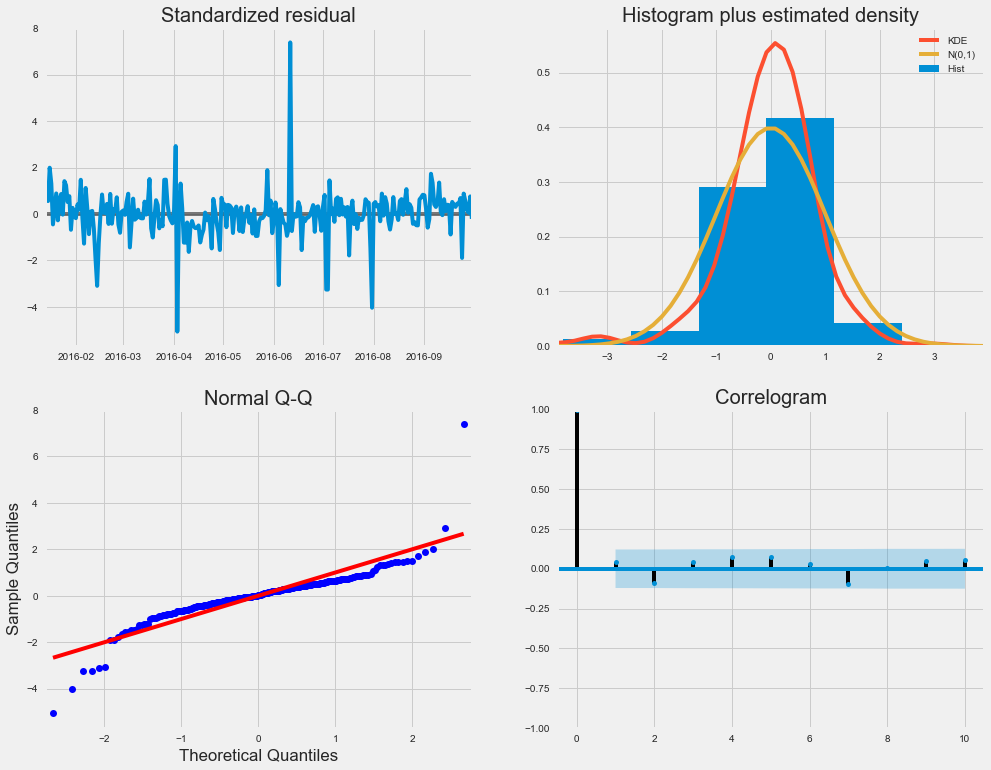

In [115]:
sarimax_result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [118]:
exog_test2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 274 entries, 2016-01-01 to 2016-09-30
Freq: D
Data columns (total 78 columns):
airconditioningtypeid               274 non-null float32
architecturalstyletypeid            274 non-null float32
basementsqft                        274 non-null float32
bedroomcnt                          274 non-null float32
buildingclasstypeid                 274 non-null float32
buildingqualitytypeid               274 non-null float32
calculatedbathnbr                   274 non-null float32
decktypeid                          274 non-null float32
finishedfloor1squarefeet            274 non-null float32
calculatedfinishedsquarefeet        274 non-null float32
finishedsquarefeet12                274 non-null float32
finishedsquarefeet13                274 non-null float32
finishedsquarefeet15                274 non-null float32
finishedsquarefeet6                 274 non-null float32
fips                                274 non-null float32
fireplacecnt 

In [122]:
exog_test2 = exog_sep16

prediction_dates = [pd.to_datetime('2016-10-01'), pd.to_datetime('2016-11-01'), pd.to_datetime('2016-12-01'),
                        pd.to_datetime('2017-10-01'), pd.to_datetime('2017-11-01'), pd.to_datetime('2017-12-01')]

#exog_test_parcelids = exog_test2[['parcelid']]
#exog_test2.drop(['parcelid'], axis = 1, inplace = True)




In [209]:
from datetime import datetime, timedelta

def get_predictions(rows, start, end):
    global predictions
    
    prediction = sarimax_result.get_prediction(start = start, end = end, dynamic = True, full_results = True, exog = rows)
    
    return prediction
    
    #year_of_prediction = date.year
    #month_of_prediction = date.month

    #prediction_column = str(year_of_prediction) + str(month_of_prediction)

    #df = pd.DataFrame(prediction.predicted_mean[0], index = range(0,1), columns = [prediction_column])
    
    #predictions[prediction_column] = predictions[prediction_column].append(df)

    
    #inner loop end
#get_predictions end

for date in prediction_dates:
    exog_test2 = exog_sep16
    
    #exog_test_with_dates = pd.DataFrame(date, index = range(0,len(exog_test2)), columns = ['transactiondate'])
    
    #exog_test2 = pd.concat([exog_test2, exog_test_with_dates], axis = 1)
    
    #exog_test2.index = exog_test2.transactiondate
    #exog_test2.drop(['transactiondate'], axis = 1, inplace = True)
    
    ##for transactiondate, row in zip(exog_test2.transactiondate, exog_test2)

start_date = pd.to_datetime('2016-09-30')
end_date = pd.to_datetime('2016-10-31')

delta = end_date - start_date

record = exog_test2[0: 1]

record = record.append([record]*(delta.days - 1))
record.index = range(0, delta.days)

datelist = pd.date_range(start_date + timedelta(days = 1), periods = delta.days, freq = 'D')
transactiondate = pd.DataFrame(datelist, columns = ['transactiondate'])

record.index = datelist
record.index.name = 'transactiondate'

record = record.groupby('transactiondate').mean()

prediction = get_predictions(record, start_date, end_date)

datelist2 = pd.date_range(start_date + timedelta(days = 1), periods = delta.days).tolist()

transactiondate2 = pd.DataFrame(datelist2, columns = ['transactiondate'])
prediction_df = pd.DataFrame(prediction.predicted_mean[1:], columns = ['prediction'])

prediction_df.index = range(0, len(prediction_df))

prediction_df = pd.concat([prediction_df, transactiondate2], axis = 1)

prediction_df.index = prediction_df.transactiondate
prediction_df.drop(['transactiondate'], axis = 1, inplace = True)

#prediction.predicted_mean.shape, transactiondate2.shape
#exog_test2.apply(lambda x: get_predictions(x, date), axis = 1)

In [141]:
record

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,...,N-taxdelinquencyyear-3,N-life,N-zip_count,N-city_count,N-ACInd,N-HeatInd,N-structuretaxvaluedollarcnt-2,N-structuretaxvaluedollarcnt-3,N-Avg-structuretaxvaluedollarcnt,N-Dev-structuretaxvaluedollarcnt
transactiondate,,,,,,,,,,,,,,,,,,,,,
2016-10-01,0.666667,0.0,0.0,3.0,0.0,2.666667,2.833333,0.0,0.0,2054.666748,...,0.0,0.0,24600.0,484754.0,1.0,1.0,4.631498e+10,1.455814e+16,174529.5,0.755907
2016-10-02,0.666667,0.0,0.0,3.0,0.0,2.666667,2.833333,0.0,0.0,2054.666748,...,0.0,0.0,24600.0,484754.0,1.0,1.0,4.631498e+10,1.455814e+16,174529.5,0.755907
2016-10-03,0.666667,0.0,0.0,3.0,0.0,2.666667,2.833333,0.0,0.0,2054.666748,...,0.0,0.0,24600.0,484754.0,1.0,1.0,4.631498e+10,1.455814e+16,174529.5,0.755907
2016-10-04,0.666667,0.0,0.0,3.0,0.0,2.666667,2.833333,0.0,0.0,2054.666748,...,0.0,0.0,24600.0,484754.0,1.0,1.0,4.631498e+10,1.455814e+16,174529.5,0.755907
2016-10-05,0.666667,0.0,0.0,3.0,0.0,2.666667,2.833333,0.0,0.0,2054.666748,...,0.0,0.0,24600.0,484754.0,1.0,1.0,4.631498e+10,1.455814e+16,174529.5,0.755907
2016-10-06,0.666667,0.0,0.0,3.0,0.0,2.666667,2.833333,0.0,0.0,2054.666748,...,0.0,0.0,24600.0,484754.0,1.0,1.0,4.631498e+10,1.455814e+16,174529.5,0.755907
2016-10-07,0.666667,0.0,0.0,3.0,0.0,2.666667,2.833333,0.0,0.0,2054.666748,...,0.0,0.0,24600.0,484754.0,1.0,1.0,4.631498e+10,1.455814e+16,174529.5,0.755907
2016-10-08,0.666667,0.0,0.0,3.0,0.0,2.666667,2.833333,0.0,0.0,2054.666748,...,0.0,0.0,24600.0,484754.0,1.0,1.0,4.631498e+10,1.455814e+16,174529.5,0.755907
2016-10-09,0.666667,0.0,0.0,3.0,0.0,2.666667,2.833333,0.0,0.0,2054.666748,...,0.0,0.0,24600.0,484754.0,1.0,1.0,4.631498e+10,1.455814e+16,174529.5,0.755907


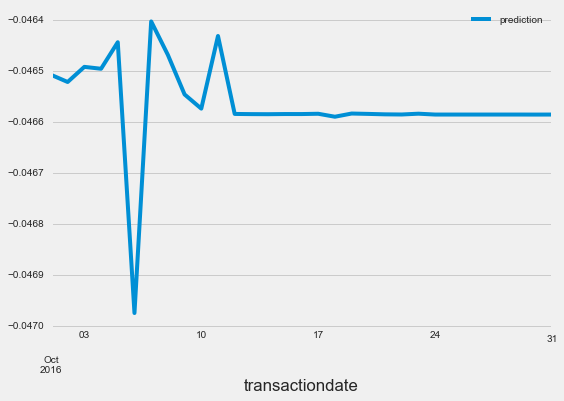

In [156]:
prediction_df.plot()
plt.show()

In [85]:
predictions['201610'].to_csv('predictions_201610.csv')

In [86]:
predictions['201611'].to_csv('predictions_201611.csv')